In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [2]:
import os
import pandas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from helper_funcs import *

In [3]:
import scipy
linkage = scipy.cluster.hierarchy.linkage
dendrogram = scipy.cluster.hierarchy.dendrogram

In [4]:
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
df = df.sort_values(by='bids_folder')
patients = df['DX_GROUP'].values==1
print(len(df))
df.head(3)

1048


,participant_id,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,...,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,bids_folder,site
460,50642,1,1.0,33.0,1,R,NaN,103.0,98.0,107.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050642,1
464,50646,1,1.0,21.0,1,R,NaN,108.0,100.0,115.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050646,1
465,50647,1,1.0,27.0,1,R,NaN,104.0,97.0,109.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050647,1


In [5]:
avail = [file for file in os.listdir(os.path.join('../Assets')) if file.startswith('cmat_latents_')]
avail.sort()
avail

['cmat_latents_CVAE_2021-10-27 11:41:44.052073.pickle',
 'cmat_latents_CVAE_2021-10-28 05:12:17.623449.pickle',
 'cmat_latents_CVAE_2021-10-28 12:51:07.008750.pickle']

In [6]:
analysis_name = 'CVAE_2021-10-27 11:41:44.052073'
analysis_name = 'CVAE_2021-10-28 05:12:17.623449'
analysis_name= 'CVAE_2021-10-28 12:51:07.008750'
latent_fn = os.path.join('../Assets',f'cmat_latents_{analysis_name}.pickle')
latent_data = pickle.load(open(latent_fn,'rb'))
data = latent_data
print(analysis_name)

CVAE_2021-10-28 12:51:07.008750


In [7]:
keys = list(latent_data.keys())
for key in keys:
    #print(f'{key} {latent_data[key].shape}')
    print(key+f'{latent_data[key].shape}'.rjust(30-len(key)))

cData           (1048, 51, 51)
Z_mu               (1048, 128)
Z_sigma            (1048, 128)
Z                  (1048, 128)
S_mu                (1048, 64)
S_sigma             (1048, 64)
S                   (1048, 64)
z_samples     (100, 1048, 128)
s_samples      (100, 1048, 64)
z_embedding           (514, 2)
s_embedding           (514, 2)
predicted       (1048, 51, 51)
predicted_bg    (1048, 51, 51)


In [8]:
import umap
reducer = umap.UMAP(n_components=2)

umap_bg_all = reducer.fit_transform(data['Z'])
umap_sl_all = reducer.fit_transform(data['S'])

umap_bg_asd = reducer.fit_transform(data['Z'][patients,:])
umap_sl_asd = reducer.fit_transform(data['S'][patients,:])

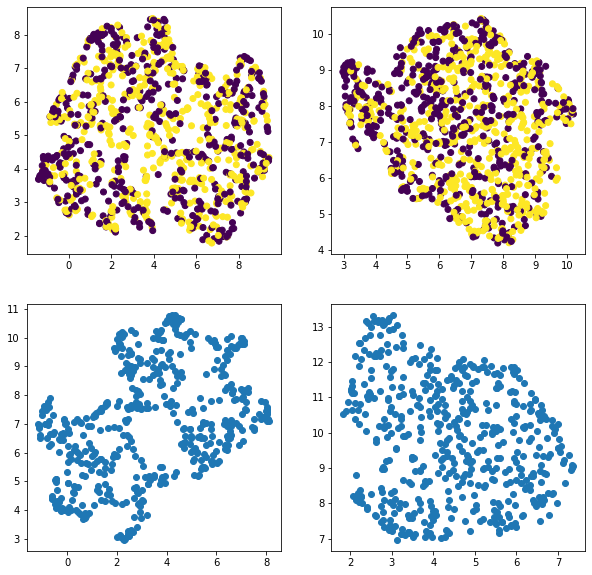

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(umap_bg_all[:,0],umap_bg_all[:,1],c=df['DX_GROUP'].values)
plt.subplot(2,2,2)
plt.scatter(umap_sl_all[:,0],umap_sl_all[:,1],c=df['DX_GROUP'].values)

plt.subplot(2,2,3)
plt.scatter(umap_bg_asd[:,0],umap_bg_asd[:,1])
plt.subplot(2,2,4)
plt.scatter(umap_sl_asd[:,0],umap_sl_asd[:,1])

In [10]:
import sklearn
from sklearn.mixture import GaussianMixture as GMM

def get_bic(mat,n_components=2):
    gmm = GMM(n_components=n_components,covariance_type='full',tol=0.001,reg_covar=1e-06,max_iter=100,n_init=1,init_params='kmeans',weights_init=None,means_init=None,precisions_init=None,random_state=None,warm_start=False,verbose=0,verbose_interval=10)
    gmm.fit(mat)
    bic = gmm.bic(mat)
    return bic

In [11]:
#ari = np.array([adjusted_rand_score(GMM(n).fit_predict(data['Z'][patients,:]),GMM(20).fit_predict(data['S'][patients,:])) for n in range(2,100)])

In [12]:
# bic_z = [get_bic(mat=data['Z'][patients,:],n_components=n_components) for n_components in range(2,101)];print('1/2')
# bic_s = [get_bic(mat=data['S'][patients,:],n_components=n_components) for n_components in range(2,101)];print('2/2')

In [13]:
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(bic_z)
# plt.subplot(1,2,2)
# plt.plot(bic_s)

In [14]:
#np.array([np.corrcoef(data['Z_mu'][i,:],data['S_mu'][i,:])[0,1] for i in range(500)]).mean()

In [15]:
rdm_z = make_RDM(data['Z'][patients,:])
rdm_s = make_RDM(data['S'][patients,:])

In [16]:
rdm_data = np.array([get_triu(data['cData'][i,:,:]) for i in range(1048)])
rdm_data = np.corrcoef(rdm_data)

<AxesSubplot:>

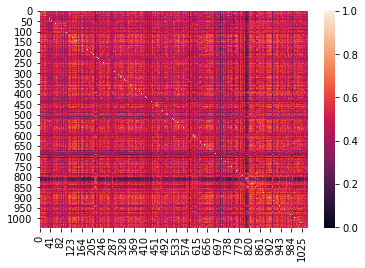

In [17]:
sns.heatmap(rdm_data)

SL-BG RDM corr 0.1613


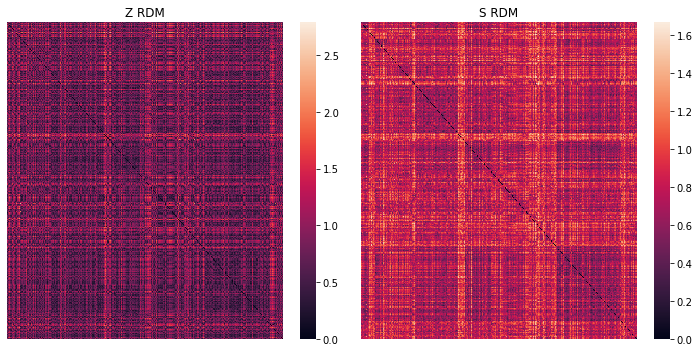

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(rdm_z,xticklabels=[],yticklabels=[]);plt.title('Z RDM')
plt.subplot(1,2,2)
sns.heatmap(rdm_s,xticklabels=[],yticklabels=[]);plt.title('S RDM')
plt.tight_layout()
print(f'SL-BG RDM corr {np.corrcoef(get_triu(rdm_s),get_triu(rdm_z))[0,1]:.4f}')

Text(0.5, 1.0, 'S')

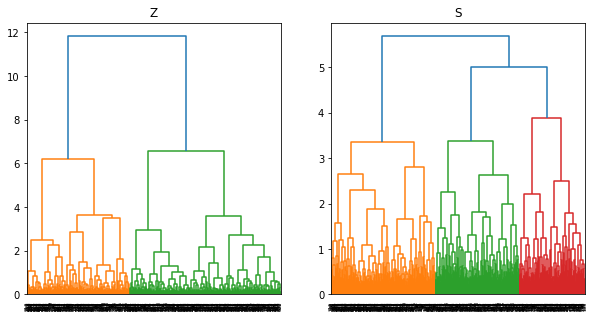

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1);dendrogram(linkage(get_triu(rdm_z),'ward'));plt.title('Z')
plt.subplot(1,2,2);dendrogram(linkage(get_triu(rdm_s),'ward'));plt.title('S')

In [20]:
rsa1 = [fit_rsa(make_RDM(data['z_samples'][i,:,:]),make_RDM(df['DX_GROUP'].values,data_scale='ordinal')) for i in range(100)]
rsa2 = [fit_rsa(make_RDM(data['s_samples'][i,:,:]),make_RDM(df['DX_GROUP'].values,data_scale='ordinal')) for i in range(100)]

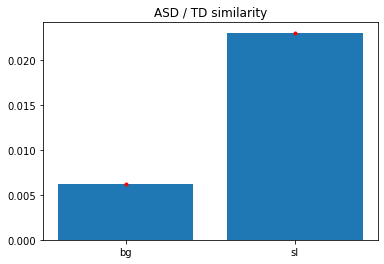

In [21]:
xs = [0,1]
ys = [np.array(rsa1).mean(),np.array(rsa2).mean()]
std = [np.array(rsa1).std(),np.array(rsa2).std()]
plt.bar(xs,ys);
plt.errorbar(xs,ys,std,fmt='r.');
plt.title('ASD / TD similarity');
plt.xticks(xs,labels=['bg','sl']);

In [22]:
sl_bg = np.array([np.corrcoef(get_triu(make_RDM(data['z_samples'][i,:,:])),get_triu(make_RDM(data['s_samples'][i,:,:])))[0,1] for i in range(100)])
sl_bg.mean().round(3)

0.19

In [23]:
# diff = data['cData']-data['predicted']
# diff = abs((data['cData']-data['cData'].mean(axis=0)) - (data['predicted']-data['predicted'].mean(axis=0)))

In [24]:
diff = abs(data['predicted'][patients,:,:]-data['predicted_bg'][patients,:,:])

In [25]:
diffs = np.array([get_triu(diff[i,:,:]) for i in range(diff.shape[0])])
rdm_diff = make_RDM(diffs)

In [26]:
umap_diffs = umap.UMAP(n_components=2).fit_transform(diffs)

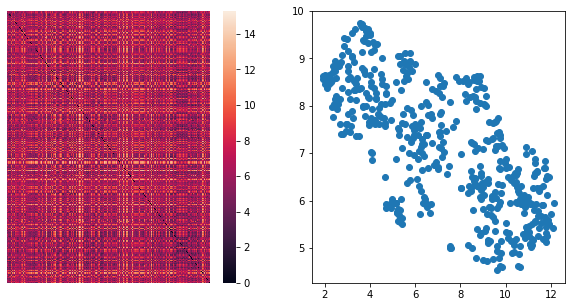

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(rdm_diff,xticklabels=[],yticklabels=[])
plt.subplot(1,2,2)
plt.scatter(umap_diffs[:,0],umap_diffs[:,1])

In [28]:
Z = linkage(diffs,method='ward', metric='euclidean', optimal_ordering=False)

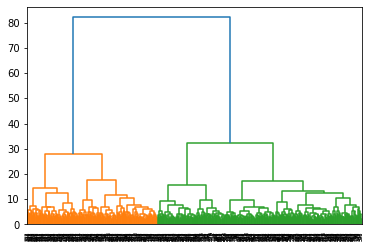

In [29]:
R = dendrogram(Z,
    p=0,
    truncate_mode=None,
    color_threshold=None,
    get_leaves=True,
    orientation='top',
    labels=None,
    count_sort=False,
    distance_sort=False,
    show_leaf_counts=True,
    no_plot=False,
    no_labels=False,
    leaf_font_size=None,
    leaf_rotation=None,
    leaf_label_func=None,
    show_contracted=False,
    link_color_func=None,
    ax=None,
    above_threshold_color='C0')

In [30]:
%%time
from tqdm import tqdm
bic_d = [get_bic(mat=rdm_diff,n_components=n_components) for n_components in range(2,20)]

CPU times: user 8min 35s, sys: 7min 22s, total: 15min 57s
Wall time: 26.8 s


### RSA

In [31]:
from scipy import stats

In [32]:
def fit_rsa(rdm_data,rdm_model):
    corr = stats.kendalltau
    #r = np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    r = corr(get_triu(rdm_data),get_triu(rdm_model))[0]
    return r

In [33]:
rdm_data_all = make_RDM(np.array([get_triu(data['cData'][i,:,:]) for i in range(data['cData'].shape[0])]))

def key_rsa(key):
    
    if key in ['site','SEX','DSM_IV_TR']:
        data_scale = 'ordinal'
    else:
        data_scale = 'ratio'
    
    subSlice = patients
    vec = df[key].values[subSlice]
    v = ~np.isnan(vec)

    metric_model = 'euclidean'
    rdm_model = make_RDM(vec[v],data_scale=data_scale,metric=metric_model)
    

    rdm_data = rdm_data_all[:,patients][patients,:]
    rdm_data = rdm_data[:,v][v,:]
    
    #rdm_model = make_RDM(vec[v],data_scale=data_scale,metric=metric_model)

    #metric_data = 'correlation'
    metric_data = 'euclidean'
    model_fit_z = np.array([fit_rsa(rdm_model,make_RDM(data['z_samples'][i,subSlice,:],metric=metric_data)[v,:][:,v]) for i in range(10)])
    model_fit_s = np.array([fit_rsa(rdm_model,make_RDM(data['s_samples'][i,subSlice,:],metric=metric_data)[v,:][:,v]) for i in range(10)])

    model_fit_data = fit_rsa(rdm_model,rdm_data)

    columns = ['key', 'bg_mean', 'bg_std', 'sl_mean', 'sl_std','n','data_scale','delta']
    res = pd.DataFrame(np.zeros(len(columns))[np.newaxis,:],columns=columns)

    res['key'] = key
    res['bg_mean'] = model_fit_z.mean()
    res['bg_std'] = model_fit_z.std()

    res['sl_mean'] = model_fit_s.mean()
    res['sl_std'] = model_fit_s.std()
    res['n'] = v.sum()
    res['data_scale'] = data_scale
    res['delta'] = model_fit_z.mean() - model_fit_s.mean()
    res['data_fit'] = model_fit_data
    
    return res

In [34]:
%%time 

keys = ['site',
 'DSM_IV_TR',
 'AGE_AT_SCAN',
 'SEX',
 'FIQ',
 'VIQ',
 'PIQ',
 'ADOS_TOTAL',
 'ADOS_COMM',
 'ADOS_SOCIAL',
 'ADOS_STEREO_BEHAV',
'ADI_R_SOCIAL_TOTAL_A',
'ADI_R_VERBAL_TOTAL_BV',
'ADI_RRB_TOTAL_C',
 'SRS_RAW_TOTAL',
 'SRS_AWARENESS',
 'SRS_COGNITION',
 'SRS_COMMUNICATION',
 'SRS_MOTIVATION']

res = pd.concat([key_rsa(key) for key in tqdm(keys)])

100%|██████████| 19/19 [00:14<00:00,  1.28it/s]

CPU times: user 14.7 s, sys: 39.2 ms, total: 14.7 s
Wall time: 14.8 s


In [35]:
#res.sort_values(by='bg_mean',ascending=False,inplace=True)
res.head()

,key,bg_mean,bg_std,sl_mean,sl_std,n,data_scale,delta,data_fit
0,site,0.045960,0.000148,0.105165,0.000040,514,ordinal,-0.059205,0.114622
0,DSM_IV_TR,0.021351,0.000245,0.028585,0.000096,477,ordinal,-0.007234,0.039851
0,AGE_AT_SCAN,-0.014871,0.000185,-0.000933,0.000061,514,ratio,-0.013938,-0.025503
0,SEX,0.007271,0.000228,0.017406,0.000078,514,ordinal,-0.010135,0.026556
0,FIQ,-0.000141,0.000189,-0.003551,0.000059,481,ratio,0.003409,0.000572


<ipython-input-36-ac56a85deb72>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols,i+1)


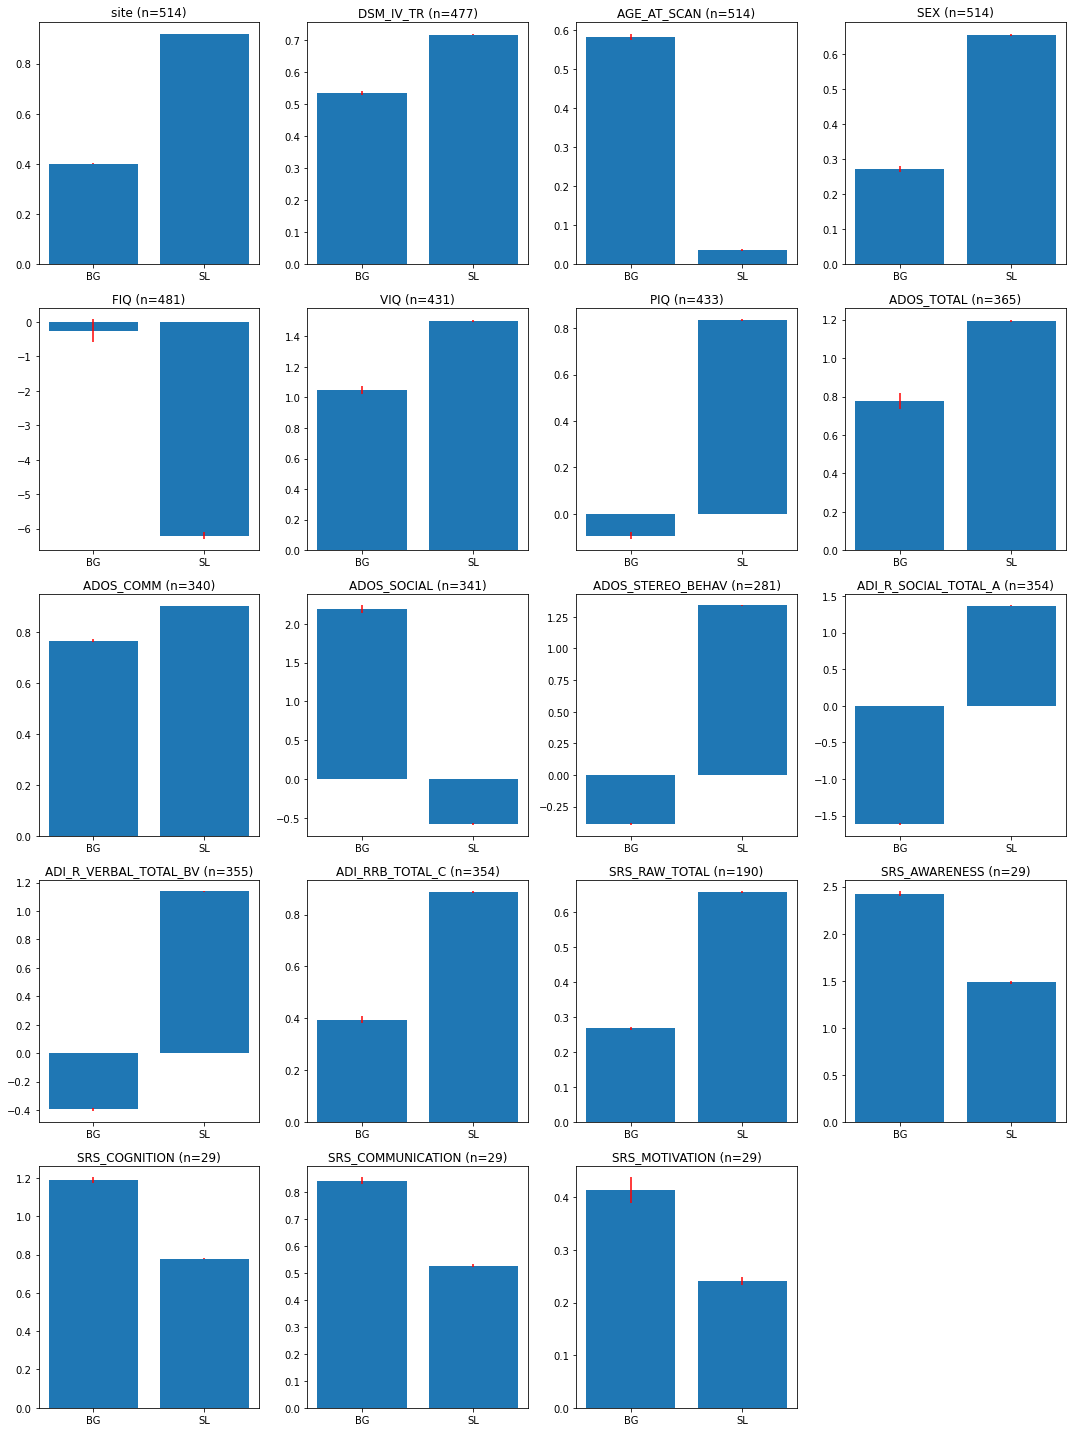

In [36]:
ncols = 4
nrows = np.ceil(len(keys)/ncols)

plt.figure(figsize=(15,4*nrows))
for i in range(len(keys)):
    plt.subplot(nrows,ncols,i+1)
    
    xs = [0,1]
    ys = [res['bg_mean'].values[i],res['sl_mean'].values[i]]
    ys = np.array(ys) / res['data_fit'].values[i]
    
    se = [res['bg_std'].values[i],res['sl_std'].values[i]]
    se = np.array(se) / res['data_fit'].values[i]

    plt.bar(xs,ys)
    plt.errorbar(xs,ys,se,fmt='r ')
    plt.xticks(xs,['BG','SL'])
    #plt.title(res['key'].values[i])
    plt.title('{} (n={})'.format(res['key'].values[i],res['n'].values[i]))
    
plt.tight_layout()

<ipython-input-37-4a0f235f9928>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols,i+1)


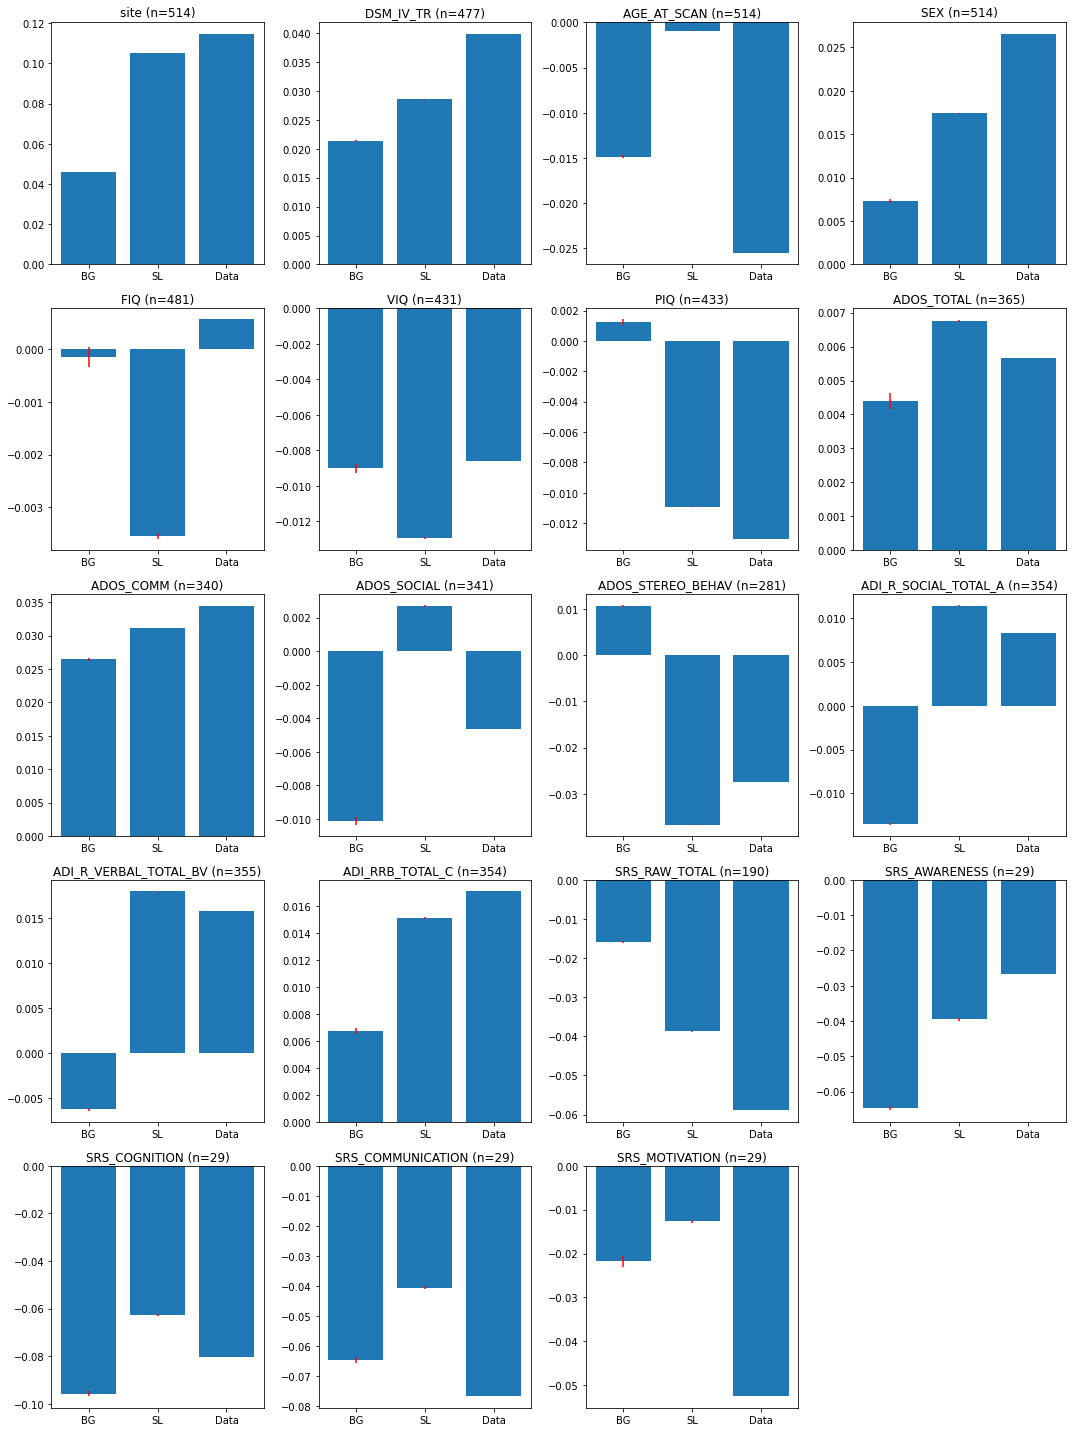

In [37]:
ncols = 4
nrows = np.ceil(len(keys)/ncols)

plt.figure(figsize=(15,4*nrows))
for i in range(len(keys)):
    plt.subplot(nrows,ncols,i+1)
    
    xs = [0,1,2]
    ys = [res['bg_mean'].values[i],res['sl_mean'].values[i],res['data_fit'].values[i]]
    se = [res['bg_std'].values[i],res['sl_std'].values[i],0]

    plt.bar(xs,ys)
    plt.errorbar(xs,ys,se,fmt='r ')
    plt.xticks(xs,['BG','SL','Data'])
    #plt.title(res['key'].values[i])
    plt.title('{} (n={})'.format(res['key'].values[i],res['n'].values[i]))
    
plt.tight_layout()

In [38]:
from sklearn.cross_decomposition import CCA

In [39]:
bg_vars = df[['AGE_AT_SCAN','DSM_IV_TR','SEX','FIQ','site']].values[patients,:]
sl_vars = df[[ 'ADOS_TOTAL',
 'ADOS_COMM',
 'ADOS_SOCIAL',
 'ADOS_STEREO_BEHAV',
'ADI_R_SOCIAL_TOTAL_A',
'ADI_R_VERBAL_TOTAL_BV',
'ADI_RRB_TOTAL_C',]].values[patients,:]

iq_vars = df[[ 'FIQ',
 'VIQ',
 'PIQ',]].values[patients,]


In [40]:
z_arr = data['Z'][patients,:]
s_arr = data['S'][patients,:]
v = ~(np.isnan(bg_vars).sum(axis=1)>0)
Y = bg_vars[v,:]
bg_cca = CCA(n_components=1)
sl_cca = CCA(n_components=1)
bg_cca.fit(z_arr[v,:],Y)
sl_cca.fit(s_arr[v,:],Y)

CCA(n_components=1)

In [41]:
[bg_cca.coef_.mean(),sl_cca.coef_.mean()]

[0.01191407135796313, -0.00893617842650701]

<BarContainer object of 2 artists>

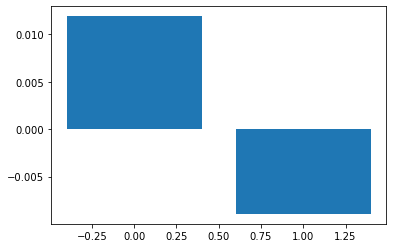

In [42]:
plt.bar([0,1],[bg_cca.coef_.mean(),sl_cca.coef_.mean()])

In [43]:
z_arr = data['Z'][patients,:]
s_arr = data['S'][patients,:]
v = ~(np.isnan(sl_vars).sum(axis=1)>0)
Y = sl_vars[v,:]
bg_cca = CCA(n_components=1)
sl_cca = CCA(n_components=1)
bg_cca.fit(z_arr[v,:],Y)
sl_cca.fit(s_arr[v,:],Y)

CCA(n_components=1)

In [44]:
[bg_cca.coef_.mean(),sl_cca.coef_.mean()]

[0.0004124494326939075, 0.008271072259473761]

<BarContainer object of 2 artists>

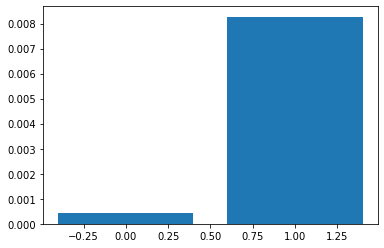

In [45]:
plt.bar([0,1],[bg_cca.coef_.mean(),sl_cca.coef_.mean()])

## PREDICTION MODELS

In [46]:
keys = ['ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',]
mat = df[keys].values
v = np.isnan(mat).sum(axis=1)==0
mat = mat[v,:]
pc = PCA(n_components=1).fit_transform(mat)
df['ADOS_PCA'] = np.nan
df['ADOS_PCA'].values[v] = pc.reshape(-1)

keys = ['ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C',
       'ADI_R_ONSET_TOTAL_D']
mat = df[keys].values
v = np.isnan(mat).sum(axis=1)==0
mat = mat[v,:]
pc = PCA(n_components=1).fit_transform(mat)
df['ADI_PCA'] = np.nan
df['ADI_PCA'].values[v] = pc.reshape(-1)

keys = ['VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED',
       'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_SCALED',
       'VINELAND_DOMESTIC_V_SCALED', 'VINELAND_COMMUNITY_V_SCALED',
       'VINELAND_DAILYLVNG_STANDARD', 'VINELAND_INTERPERSONAL_V_SCALED',
       'VINELAND_PLAY_V_SCALED', 'VINELAND_COPING_V_SCALED',
       'VINELAND_SOCIAL_STANDARD', 'VINELAND_SUM_SCORES',
       'VINELAND_ABC_STANDARD', 'VINELAND_INFORMANT']
mat = df[keys].values
v = np.isnan(mat).sum(axis=1)==0
mat = mat[v,:]
pc = PCA(n_components=1).fit_transform(mat)
df['VINELAND_PCA'] = np.nan
df['VINELAND_PCA'].values[v] = pc.reshape(-1)

In [47]:
n = latent_data['cData'].shape[0]

In [48]:
latent_data['cTriu'] = np.array([get_triu(latent_data['cData'][i,:,:]) for i in range(n)])

In [49]:
def get_reg_stats(X,Y):
    import statsmodels.api as sm
    #X = X_c
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    #print(est2.summary())
    return est2

In [50]:
def y_yh_scatter(Y,y_hats):
    plt.scatter(Y,y_hats)

    r = np.corrcoef(Y,y_hats)[0,1]
    b,c = np.polyfit(Y,y_hats,1)
    plt.plot(Y,(Y*b)+c,'r-')

    plt.title(f'r = {r:.2f},b = {b:.2f}')
    plt.xlim(min(Y)-.1,max(Y)+.1)
    plt.ylim(min(Y)-.1,max(Y)+.1)

In [51]:
def slice_df(key):
    #key = ['ADOS_TOTAL']
    X_s = latent_data['S'][patients,:]
    X_z = latent_data['Z'][patients,:]
    cdata = latent_data['cTriu'][patients,:]
    
    Y = df[key].values[patients]
    v = ~np.isnan(Y)#[:,0]
    v = v.reshape(-1)

    X_s = X_s[v,:]
    X_z = X_z[v,:]
    Y = Y[v]
    cdata = cdata[v,:]
    cdata = PCA(n_components=10).fit_transform(cdata)
    #print(X.shape)
    #print(Y.shape)
    
    slice_ = dict()
    slice_['X_s'] = X_s
    slice_['X_z'] = X_z
    slice_['triu'] = cdata
    slice_['Y'] = Y
    
    #[print(slice_[key].shape) for key in list(slice_.keys())];
    
    return slice_

In [52]:
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import zscore
from operator import itemgetter

from sklearn.neural_network import MLPRegressor

In [53]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,ElasticNet,BayesianRidge,Lasso
from sklearn.model_selection import cross_val_score
svr_reg = SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=- 1)
dt_reg = DecisionTreeRegressor()
#NN_reg = MLPRegressor(hidden_layer_sizes=(8),activation='relu',solver='adam',alpha=0.0001,batch_size='auto',learning_rate='constant',learning_rate_init=0.001,max_iter=1000)

clf = Ridge()
#clf = dt_reg
#clf = NN_reg
#clf = svr_reg
#clf = LinearRegression()

In [54]:
nsubs = latent_data['Z_mu'][patients,:].shape[0]

In [55]:
def norm(vec):
    return (vec-vec.min())/(vec.max()-vec.min())

In [56]:
def loso(X,Y,clf):
    y_hats = list()
    nsubs = len(Y)
    for i in tqdm(np.arange(nsubs)):
        sub_slice = np.arange(nsubs)!=i
        clf.fit(X[sub_slice,:],Y[sub_slice])
        y_hat = clf.predict(X[i,:][np.newaxis,:])
        y_hats.append(y_hat)

    y_hats = np.array(y_hats)[:,0]
    return y_hats

100%|██████████| 514/514 [00:00<00:00, 1632.61it/s]


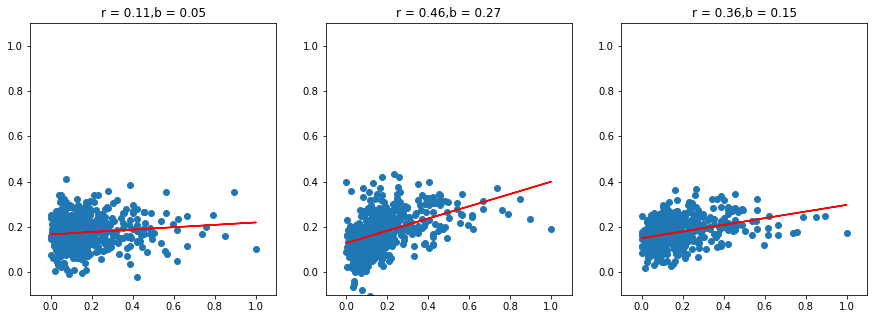

In [57]:
slice_ = slice_df('AGE_AT_SCAN')
X_z,X_s,cTriu,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

Y = norm(Y)
yh_s = loso(X_s,Y,clf)
yh_z = loso(X_z,Y,clf)
yh_c = loso(cTriu,Y,clf)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1);y_yh_scatter(Y,yh_z)
plt.subplot(1,3,2);y_yh_scatter(Y,yh_s)
plt.subplot(1,3,3);y_yh_scatter(Y,yh_c)

100%|██████████| 481/481 [00:00<00:00, 1659.21it/s]


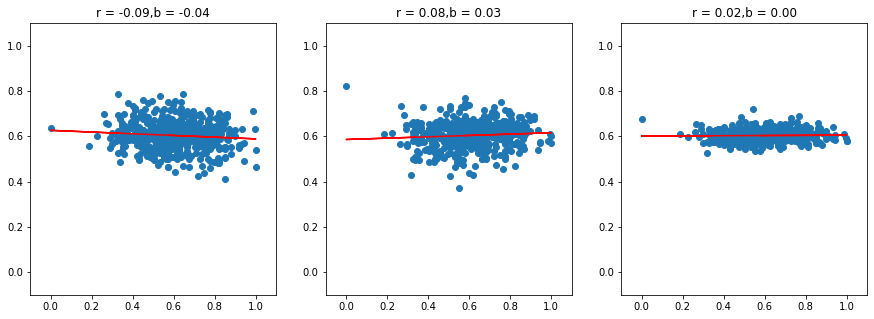

In [58]:
slice_ = slice_df('FIQ')
X_z,X_s,cTriu,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

Y = norm(Y)

yh_s = loso(X_s,Y,clf)
yh_z = loso(X_z,Y,clf)
yh_c = loso(cTriu,Y,clf)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1);y_yh_scatter(Y,yh_z)
plt.subplot(1,3,2);y_yh_scatter(Y,yh_s)
plt.subplot(1,3,3);y_yh_scatter(Y,yh_c)

100%|██████████| 365/365 [00:00<00:00, 1495.42it/s]


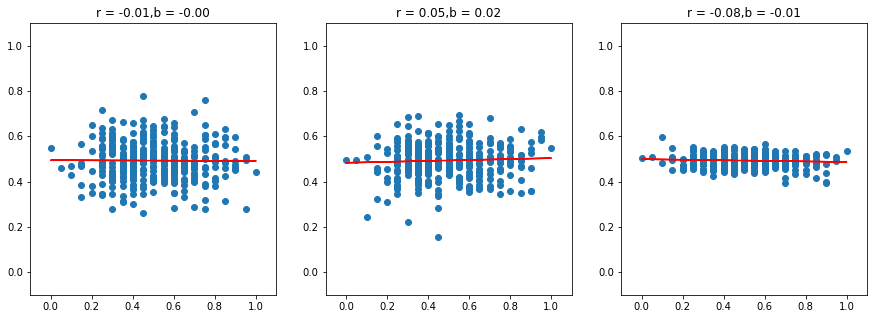

In [59]:
slice_ = slice_df('ADOS_TOTAL')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

Y = norm(Y)
yh_s = loso(X_s,Y,clf)
yh_z = loso(X_z,Y,clf)
yh_c = loso(X_c,Y,clf)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1);y_yh_scatter(Y,yh_z)
plt.subplot(1,3,2);y_yh_scatter(Y,yh_s)
plt.subplot(1,3,3);y_yh_scatter(Y,yh_c)

100%|██████████| 341/341 [00:00<00:00, 1218.80it/s]


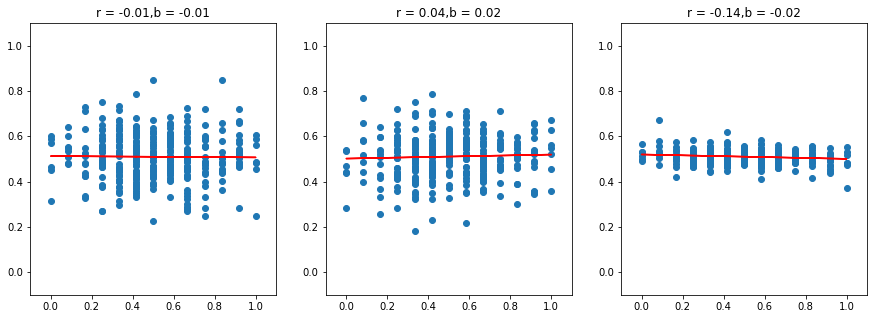

In [60]:
slice_ = slice_df('ADOS_SOCIAL')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

#Y = zscore(Y)
Y = norm(Y)
yh_s = loso(X_s,Y,clf)
yh_z = loso(X_z,Y,clf)
yh_c = loso(X_c,Y,clf)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1);y_yh_scatter(Y,yh_z)
plt.subplot(1,3,2);y_yh_scatter(Y,yh_s)
plt.subplot(1,3,3);y_yh_scatter(Y,yh_c)

100%|██████████| 50/50 [00:00<00:00, 1619.22it/s]


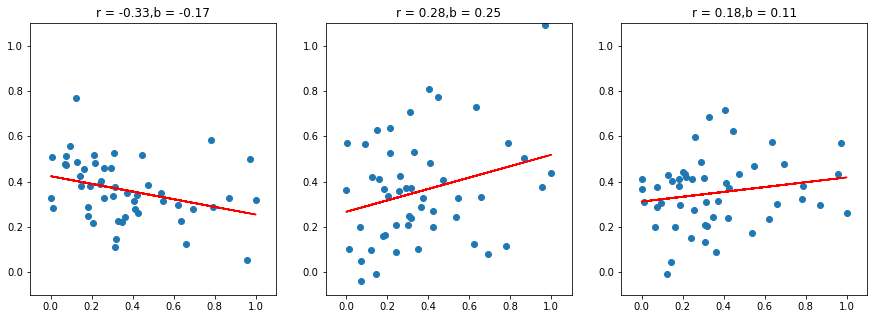

In [61]:
slice_ = slice_df('BMI')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

#Y = zscore(Y)
Y = norm(Y)
yh_s = loso(X_s,Y,clf)
yh_z = loso(X_z,Y,clf)
yh_c = loso(X_c,Y,clf)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1);y_yh_scatter(Y,yh_z)
plt.subplot(1,3,2);y_yh_scatter(Y,yh_s)
plt.subplot(1,3,3);y_yh_scatter(Y,yh_c)

100%|██████████| 281/281 [00:00<00:00, 1359.55it/s]


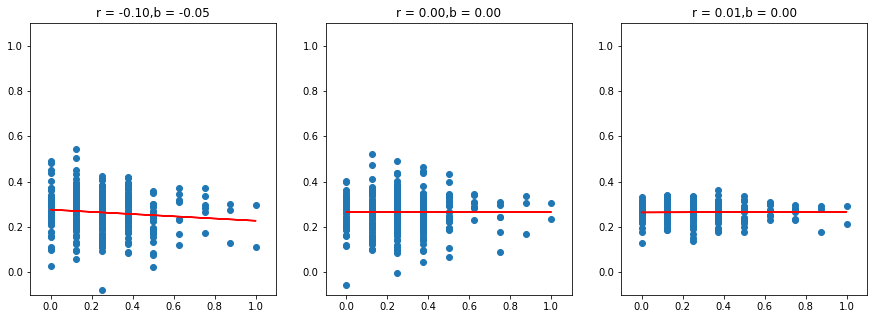

In [62]:
slice_ = slice_df('ADOS_STEREO_BEHAV')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

#Y = zscore(Y)
Y = norm(Y)
yh_s = loso(X_s,Y,clf)
yh_z = loso(X_z,Y,clf)
yh_c = loso(X_c,Y,clf)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1);y_yh_scatter(Y,yh_z)
plt.subplot(1,3,2);y_yh_scatter(Y,yh_s)
plt.subplot(1,3,3);y_yh_scatter(Y,yh_c)

100%|██████████| 282/282 [00:00<00:00, 1519.95it/s]


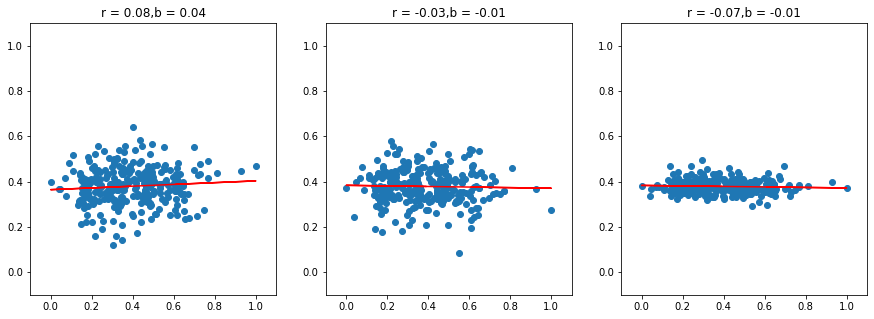

In [63]:
slice_ = slice_df('ADI_PCA')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

#Y = zscore(Y)
Y = norm(Y)
yh_s = loso(X_s,Y,clf)
yh_z = loso(X_z,Y,clf)
yh_c = loso(X_c,Y,clf)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1);y_yh_scatter(Y,yh_z)
plt.subplot(1,3,2);y_yh_scatter(Y,yh_s)
plt.subplot(1,3,3);y_yh_scatter(Y,yh_c)

100%|██████████| 280/280 [00:00<00:00, 1376.66it/s]


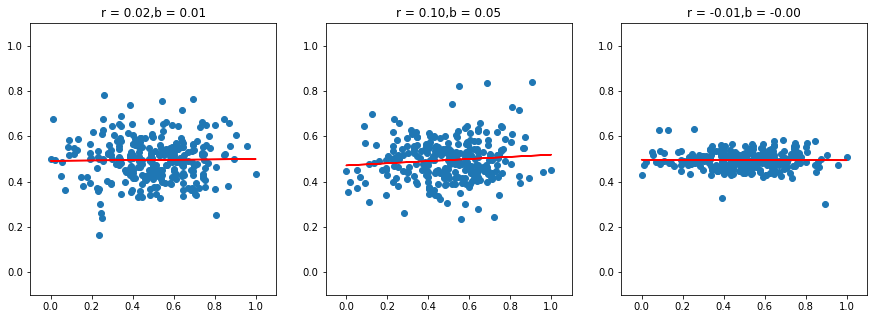

In [64]:
slice_ = slice_df('ADOS_PCA')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

#Y = zscore(Y)
Y = norm(Y)
yh_s = loso(X_s,Y,clf)
yh_z = loso(X_z,Y,clf)
yh_c = loso(X_c,Y,clf)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1);y_yh_scatter(Y,yh_z)
plt.subplot(1,3,2);y_yh_scatter(Y,yh_s)
plt.subplot(1,3,3);y_yh_scatter(Y,yh_c)

100%|██████████| 69/69 [00:00<00:00, 2278.92it/s]


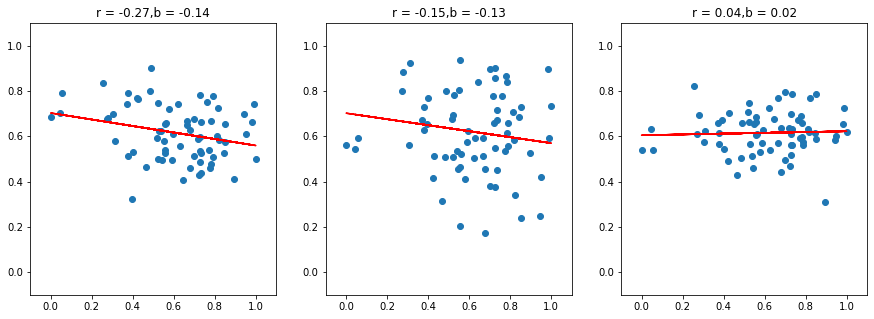

In [65]:
slice_ = slice_df('VINELAND_SUM_SCORES')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

#Y = zscore(Y)
Y = norm(Y)
yh_s = loso(X_s,Y,clf)
yh_z = loso(X_z,Y,clf)
yh_c = loso(X_c,Y,clf)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1);y_yh_scatter(Y,yh_z)
plt.subplot(1,3,2);y_yh_scatter(Y,yh_s)
plt.subplot(1,3,3);y_yh_scatter(Y,yh_c)

In [66]:
def plot_clf_bar(clf_res):
    acc_z = (clf_res['yh_z']==clf_res['Y']).mean().round(2)
    acc_s = (clf_res['yh_s']==clf_res['Y']).mean().round(2)
    acc_c = (clf_res['yh_c']==clf_res['Y']).mean().round(2)
    Y = clf_res['Y']
    ys = [acc_z,acc_s,acc_c];
    xs = np.arange(len(ys));
    plt.bar(xs,ys);
    plt.xticks(xs,labels=['Z','S','C']);
    plt.plot((xs.min()-.5,xs.max()+.5),np.repeat(1/len(np.unique(Y)),2),'k')
    plt.title(clf_res['key'])

In [67]:
def loso(X,Y,clf):
    y_hats = list()
    nsubs = len(Y)
    for i in tqdm(np.arange(nsubs)):
        sub_slice = np.arange(nsubs)!=i
        clf.fit(X[sub_slice,:],Y[sub_slice])
        y_hat = clf.predict(X[i,:][np.newaxis,:])
        y_hats.append(y_hat)

    y_hats = np.array(y_hats)[:,0]
    return y_hats

In [68]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [81]:
clf = SVC(C=1.0,kernel='linear',degree=3,gamma='scale',coef0=0.0,shrinking=True,probability=False,tol=0.001,cache_size=200,class_weight='balanced')
#clf = LogisticRegression(penalty='l2',dual=False,tol=0.0001,C=1.0,fit_intercept=True,intercept_scaling=1,class_weight='balanced',random_state=None,solver='lbfgs',max_iter=1000,multi_class='auto',verbose=0,warm_start=False,n_jobs=None,l1_ratio=None)
#clf = LogisticRegression(class_weight='balanced',max_iter=500)
#clf = DecisionTreeClassifier(class_weight='balanced')

100%|██████████| 514/514 [00:03<00:00, 145.21it/s]


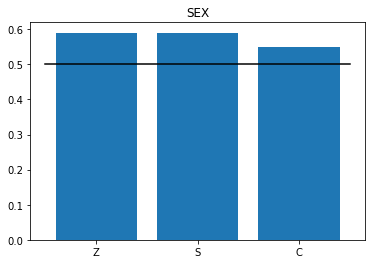

In [82]:
key = 'SEX'
slice_ = slice_df(key)
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

clf_res = dict()
clf_res['yh_z'] = loso(X_z,Y,clf)
clf_res['yh_s'] = loso(X_s,Y,clf)
clf_res['yh_c'] = loso(X_c,Y,clf)
clf_res['key'] = key
clf_res['Y'] = Y

plot_clf_bar(clf_res)

In [ ]:
key = 'DSM_IV_TR'
slice_ = slice_df(key)
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

clf_res = dict()
clf_res['yh_z'] = loso(X_z,Y,clf)
clf_res['yh_s'] = loso(X_s,Y,clf)
clf_res['yh_c'] = loso(X_c,Y,clf)
clf_res['key'] = key
clf_res['Y'] = Y

plot_clf_bar(clf_res)

In [ ]:
key = 'site'
slice_ = slice_df(key)
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

clf_res = dict()
clf_res['yh_z'] = loso(X_z,Y,clf)
clf_res['yh_s'] = loso(X_s,Y,clf)
clf_res['yh_c'] = loso(X_c,Y,clf)
clf_res['key'] = key
clf_res['Y'] = Y
plot_clf_bar(clf_res)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
latent_data['cPCA'] = PCA(n_components=15).fit_transform(latent_data['cTriu'])

In [ ]:
#bv = ['participant_id','DSM_IV_TR', 'AGE_AT_SCAN', 'FIQ','SEX','VIQ', 'PIQ','ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',]
#bv = ['participant_id','ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV']
bv = ['participant_id','BMI']

bvmat = df[bv].dropna().values
pids = bvmat[:,0].astype(int)
#bvmat = np.array([norm(bvmat[:,i]) for i in range(1,bvmat.shape[1])]).transpose()

vv = np.array([pid in pids for pid in df['participant_id'].values])

X_z = latent_data['Z'][vv,:]
X_s = latent_data['S'][vv,:]
X_c = latent_data['cPCA'][vv,:]

Y = KMeans(n_clusters=4).fit_predict(bvmat)

clf_res = dict()
clf_res['yh_z'] = loso(X_z,Y,clf)
clf_res['yh_s'] = loso(X_s,Y,clf)
clf_res['yh_c'] = loso(X_c,Y,clf)
clf_res['key'] = 'B. subtypes'
clf_res['Y'] = Y
plot_clf_bar(clf_res)

In [ ]:
key = 'DSM_IV_TR'
slice_ = slice_df(key)
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

In [ ]:
df.columns

In [ ]:
[print('{} | {}'.format(key,len(df[key][patients].dropna().values))) for key in list(df.columns)];